In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import matplotlib.pyplot as plt
import numpy as np
import copy
import PIL
import os
from skimage import color
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from nuscenes.utils.data_classes import LidarPointCloud
from pyquaternion import Quaternion
#nusc = NuScenes(version='v1.0-mini', dataroot='data/sets/nuscenes', verbose=True)
nusc = NuScenes(version='v1.0-trainval', dataroot='full_data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 31.8 seconds.
Reverse indexing ...
Done reverse indexing in 11.2 seconds.


In [2]:
import os.path as osp

In [3]:
# def project_points_to_BEV(pc, lidar_data, pose_record):
#     cs_record = nusc.get('calibrated_sensor', lidar_data['calibrated_sensor_token'])
    
#     ref_to_ego = transform_matrix(translation=cs_record['translation'],
#                                   rotation=Quaternion(cs_record["rotation"]))

#     # Compute rotation between 3D vehicle pose and "flat" vehicle pose (parallel to global z plane).
#     ego_yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
#     rotation_vehicle_flat_from_vehicle = np.dot(
#         Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
#         Quaternion(pose_record['rotation']).inverse.rotation_matrix)
#     vehicle_flat_from_vehicle = np.eye(4)
#     vehicle_flat_from_vehicle[:3, :3] = rotation_vehicle_flat_from_vehicle
#     viewpoint = np.dot(vehicle_flat_from_vehicle, ref_to_ego) 
#     points = view_points(pc.points[:3, :], viewpoint, normalize=False)
#     return points

In [4]:
palette = {}

palette['Bird'] = [165, 42, 42]
palette['Ground Animal'] = [0, 192, 0]
palette['Curb'] = [196, 196, 196]
palette['Fence'] = [190, 153, 153]
palette['Guard Rail'] = [180, 165, 180]
palette['Barrier'] = [90, 120, 150]
palette['Wall'] = [102, 102, 156]
palette['Bile Lane'] = [128, 64, 255]
palette['Crosswalk - Plain'] = [140, 140, 200]
palette['Curb Cut'] = [170, 170, 170]
palette['Parking'] = [250, 170, 160]
palette['Pedestrian Area'] = [96, 96, 96]
palette['Rail Track'] = [230, 150, 140]
palette['Road'] = [128, 64, 128]
palette['Service Lane'] = [110, 110, 110]
palette['Sidewalk'] = [244, 35, 232]
palette['Bridge'] = [150, 100, 100]
palette['Building'] = [70, 70, 70]
palette['Tunnel'] = [150, 120, 90]
palette['Person'] = [220, 20, 60]
palette['Bicyclist'] = [255, 0, 0]
palette['Motorcyclist'] = [255, 0, 100]
palette['Other Rider'] = [255, 0, 200]
palette['Lane Marking - Crosswalk'] = [200, 128, 128]
palette['Lane Marking - General'] = [255, 255, 255]
palette['Mountain'] = [64, 170, 64]
palette['Sand'] = [230, 160, 50]
palette['Sky'] = [70, 130, 180]
palette['Snow'] = [190, 255, 255]
palette['Terrain'] = [152, 251, 152]
palette['Vegetation'] = [107, 142, 35]
palette['Water'] = [0, 170, 30]
palette['Banner'] = [255, 255, 128]
palette['Bench'] = [250, 0, 30]
palette['Bike Rack'] = [100, 140, 180]
palette['Billboard'] = [220, 220, 220]
palette['Catch Basin'] = [220, 128, 128]
palette['CCTV Camera'] = [222, 40, 40]
palette['Fire Hydrant'] = [100, 170, 30]
palette['Junction Box'] = [40, 40, 40]
palette['Mailbox'] = [33, 33, 33]
palette['Manhole'] = [100, 128, 160]
palette['Phone Booth'] = [142, 0, 0]
palette['Pothole'] = [70, 100, 150]
palette['Street Light'] = [210, 170, 100]
palette['Pole'] = [153, 153, 153]
palette['Traffic Sign Frame'] = [128, 128, 128]
palette['Utility Pole'] = [0, 0, 80]
palette['Traffic Light'] = [250, 170, 30]
palette['Traffic Sign (Back)'] = [192, 192, 192]
palette['Traffic Sign (Front)'] = [220, 220, 0]
palette['Trash Can'] = [140, 140, 20]
palette['Bicycle'] = [119, 11, 32]
palette['Boat'] = [150, 0, 255]
palette['Bus'] = [0, 60, 100]
palette['Car'] = [0, 0, 142]
palette['Caravan'] = [0, 0, 90]
palette['Motorcycle'] = [0, 0, 230]
palette['On Rails'] = [0, 80, 100]
palette['Other Vehicle'] = [128, 64, 64]
palette['Trailer'] = [0, 0, 110]
palette['Truck'] = [0, 0, 70]
palette['Wheeled Slow'] = [0, 0, 192]
palette['Car Mount'] = [32, 32, 32]
palette['Ego Vehicle'] = [120, 10, 10]

for k in palette.keys():
    palette[k].append(255)

In [5]:
pixel_to_classidx = {}
class_to_idx = {}
count = 0 
for k in palette: 
    pixel_to_classidx[tuple(palette[k])] = (k, count)
    class_to_idx[k] = count
    count+=1

In [6]:
class_to_idx
idx_to_class = {class_to_idx[k] : k for k in class_to_idx}
idx_to_class

{0: 'Bird',
 1: 'Ground Animal',
 2: 'Curb',
 3: 'Fence',
 4: 'Guard Rail',
 5: 'Barrier',
 6: 'Wall',
 7: 'Bile Lane',
 8: 'Crosswalk - Plain',
 9: 'Curb Cut',
 10: 'Parking',
 11: 'Pedestrian Area',
 12: 'Rail Track',
 13: 'Road',
 14: 'Service Lane',
 15: 'Sidewalk',
 16: 'Bridge',
 17: 'Building',
 18: 'Tunnel',
 19: 'Person',
 20: 'Bicyclist',
 21: 'Motorcyclist',
 22: 'Other Rider',
 23: 'Lane Marking - Crosswalk',
 24: 'Lane Marking - General',
 25: 'Mountain',
 26: 'Sand',
 27: 'Sky',
 28: 'Snow',
 29: 'Terrain',
 30: 'Vegetation',
 31: 'Water',
 32: 'Banner',
 33: 'Bench',
 34: 'Bike Rack',
 35: 'Billboard',
 36: 'Catch Basin',
 37: 'CCTV Camera',
 38: 'Fire Hydrant',
 39: 'Junction Box',
 40: 'Mailbox',
 41: 'Manhole',
 42: 'Phone Booth',
 43: 'Pothole',
 44: 'Street Light',
 45: 'Pole',
 46: 'Traffic Sign Frame',
 47: 'Utility Pole',
 48: 'Traffic Light',
 49: 'Traffic Sign (Back)',
 50: 'Traffic Sign (Front)',
 51: 'Trash Can',
 52: 'Bicycle',
 53: 'Boat',
 54: 'Bus',
 55: 

In [7]:
def get_seg(og_seg, plot_images=False, colortype='rgb'):
    '''
    og_seg - image from which intermediate representations will be extracted from (array)
    plot_images - plots images if True, does not plot if False
    colortype - 'binary': plots 1 or 0 (used for occupancy grid), 'grayscale': plots in grayscale for lidar mapping,
                'rgb' or any other string: plots in original palette colors
    returns ret - list of intermediate representations(road, lane, and obstacle in that order so far)
    '''
    if(plot_images):
        plt.figure()
        plt.imshow(og_seg)
    ret = []
    #road segmentation
    inter_seg_road = copy.deepcopy(og_seg)
    inter_seg_road[(og_seg != palette['Road']).any(axis=2)] = [0,0,0,255]  
    ret.append(inter_seg_road)
    
    #lane segmentation
    inter_seg_lane = copy.deepcopy(og_seg)
    crosswalk = (og_seg != palette['Lane Marking - Crosswalk']).any(axis=2)
    general = (og_seg != palette['Lane Marking - General']).any(axis=2) 
    inter_seg_lane[np.logical_and(crosswalk, general)] = [0,0,0,255] 
    ret.append(inter_seg_lane)
    
    #obstacle segmentation (did not include Curb Cut as obstacle but did include Curb)
    inter_seg_obstacle = copy.deepcopy(og_seg)
    building = (og_seg != palette['Building']).any(axis=2)
    curb = (og_seg != palette['Curb']).any(axis=2)
    vegetation = (og_seg != palette['Vegetation']).any(axis=2)
    inter_seg_obstacle[np.logical_and(np.logical_and(building,curb),vegetation)] = [0,0,0,255]
    ret.append(inter_seg_obstacle)
    
    if(colortype == 'grayscale'):
        for i in range(0, len(ret)):
            temp = color.rgb2gray(ret[i])
            ret[i] = temp
            
    elif(colortype == 'binary'):
        for i in range(0, len(ret)):
            temp = color.rgb2gray(ret[i])
            temp[temp > 0] = 1
            ret[i] = temp
    
    
    if(plot_images):
        for i in ret:
            plt.figure()
            if(colortype =='grayscale'):
                plt.imshow(i, cmap='gray')
            else:
                plt.imshow(i)
    return ret
    
    

In [8]:
def get_semantic_class(points, cam_img):
    num_points = points.shape[1]
    
    class_vec = [-1] * num_points
    num_points_classified = 0
    for i in range(num_points):
        current_point = np.round(points[:,i][:2])
        r = int(current_point[0])
        c = int(current_point[1])
        object_type, class_id = pixel_to_classidx[(tuple(cam_img[c,r]))]
        class_vec[i] = class_id
        num_points_classified+=1
#     print(str(num_points_classified) + '/' + str(len(class_vec)))
            
    return class_vec

In [9]:
def project_points_to_image(current_pc, pointsensor, cam):
    
    pc = copy.deepcopy(current_pc)
    # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # First step: transform the point-cloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))
    
#     import pdb; pdb.set_trace()
    # Second step: transform to the global frame.
    poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))
    
    t2 = transform_matrix(translation=poserecord['translation'],rotation=Quaternion(poserecord['rotation']),inverse=True)
#     import pdb; pdb.set_trace()
    global_frame_pc = copy.deepcopy(pc)

    # Third step: transform into the ego vehicle frame for the timestamp of the image.
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    pc.translate(-np.array(poserecord['translation']))
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

    # Fourth step: transform into the camera.
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)
    
    return pc, global_frame_pc
    

In [10]:
def mask_img_points(points, depths, im, min_dist=1.0):
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
    return mask

In [11]:
import math

In [12]:


my_scene_token = nusc.field2token('scene', 'name', 'scene-0103')[0]
scene_rec = nusc.get('scene', my_scene_token)

current_token = scene_rec['first_sample_token']
has_more = True 
scene_rec
count = 0 
history = []
plot_result = True
for i in range(scene_rec['nbr_samples']): 
    
    #get current sample data
    sample_rec = nusc.get('sample', current_token)

    #get camera tokens
    camera_token = sample_rec['data']['CAM_FRONT']
    camera_token_FRONT_LEFT = sample_rec['data']['CAM_FRONT_LEFT']
    camera_token_FRONT_RIGHT = sample_rec['data']['CAM_FRONT_RIGHT']
    camera_token_BACK = sample_rec['data']['CAM_BACK']

    #get lidar data info
    pointsensor_token = sample_rec['data']['LIDAR_TOP']
    pointsensor = nusc.get('sample_data', pointsensor_token)

    #get camera info
    cam = nusc.get('sample_data', camera_token)
    cam_front_left = nusc.get('sample_data', camera_token_FRONT_LEFT)
    cam_front_right = nusc.get('sample_data', camera_token_FRONT_RIGHT)
    cam_back = nusc.get('sample_data', camera_token_BACK)
    
    orig_pc, times = LidarPointCloud.from_file_multisweep(nusc, sample_rec, 'LIDAR_TOP', 'LIDAR_TOP', nsweeps=1)
    
    #get ego vehicle pose
    pose_record = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    
    #get point cloud in camera frame prior to putting inside image plane
    pc, global_frame_pc = project_points_to_image(orig_pc, pointsensor, cam) 
    pc_front_left, _ = project_points_to_image(orig_pc, pointsensor, cam_front_left)
    pc_front_right, _ = project_points_to_image(orig_pc, pointsensor, cam_front_right)
    pc_back, _ = project_points_to_image(orig_pc, pointsensor, cam_back)
  
    #get image representation of camera data
    im = PIL.Image.open(osp.join(nusc.dataroot, cam['filename']))
    im_fl = PIL.Image.open(osp.join(nusc.dataroot, cam_front_left['filename']))
    im_fr = PIL.Image.open(osp.join(nusc.dataroot, cam_front_right['filename']))
    im_b = PIL.Image.open(osp.join(nusc.dataroot, cam_back['filename']))

     # Grab the depths (camera frame z axis points away from the camera).
    depths = pc.points[2, :]
    depths_front_left = pc_front_left.points[2,:]
    depths_front_right = pc_front_right.points[2,:]
    depths_back = pc_back.points[2,:]
    
    print(osp.join(nusc.dataroot, cam['filename']))
    print(osp.join(nusc.dataroot, cam_front_left['filename']))
    print(osp.join(nusc.dataroot, cam_front_right['filename']))
    print(osp.join(nusc.dataroot, cam_back['filename']))

    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    cs_record_front_left = nusc.get('calibrated_sensor', cam_front_left['calibrated_sensor_token'])
    cs_record_front_right = nusc.get('calibrated_sensor', cam_front_right['calibrated_sensor_token'])
    cs_record_back = nusc.get('calibrated_sensor', cam_back['calibrated_sensor_token'])
    
    #get matrix representation of camera image
    cam_data_arr_front = plt.imread(osp.join(nusc.dataroot, cam['filename']))
    cam_data_arr_front_left = plt.imread(osp.join(nusc.dataroot, cam_front_left['filename']))
    cam_data_arr_front_right = plt.imread(osp.join(nusc.dataroot, cam_front_right['filename']))
    cam_data_arr_back = plt.imread(osp.join(nusc.dataroot, cam_back['filename']))
    
    #get point cloud data in the image plane across all cameras
    points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)
    points_front_left = view_points(pc_front_left.points[:3, :], np.array(cs_record_front_left['camera_intrinsic']), normalize=True)
    points_front_right = view_points(pc_front_right.points[:3, :], np.array(cs_record_front_right['camera_intrinsic']), normalize=True)
    points_back = view_points(pc_back.points[:3, :], np.array(cs_record_back['camera_intrinsic']), normalize=True)

    #get points that are actually inside the image plane
    mask_front = mask_img_points(points, depths, im)
    mask_front_left = mask_img_points(points_front_left, depths_front_left, im_fl)
    mask_front_right = mask_img_points(points_front_right, depths_front_right, im_fr)
    mask_back = mask_img_points(points_back, depths_back, im_b)
    
    # get points inside the image
    valid_img_points_front = points[:, mask_front]
    valid_img_points_front_left = points_front_left[:, mask_front_left]
    valid_img_points_front_right = points_front_right[:, mask_front_right]
    valid_img_points_back = points_back[:, mask_back]
    
    #perform point painting and get class per associated valid lidar point
    semantic_class_points_front = get_semantic_class(valid_img_points_front, cam_data_arr_front)   
    
    semantic_class_points_front_left = get_semantic_class(valid_img_points_front_left, cam_data_arr_front_left)   

    semantic_class_points_front_right = get_semantic_class(valid_img_points_front_right, cam_data_arr_front_right)   
    semantic_class_points_back = get_semantic_class(valid_img_points_back, cam_data_arr_back)   
    
    masks = [mask_front, mask_front_left, mask_front_right, mask_back]
    semantic_class_points = [semantic_class_points_front,\
                             semantic_class_points_front_left,\
                             semantic_class_points_front_right,\
                             semantic_class_points_back]
    
    
    history.append((pc, global_frame_pc, pointsensor, pose_record, masks, semantic_class_points))
    #can take history and predict
    if i >= 2*past_seconds and i <= scene_rec['nbr_samples'] - 2*future_seconds: 
        needed_history = history[-(2*past_seconds+1):-1]
        needed_ego_pose = history[-1][3]
        
        res = 0.75
        offset = 64
        
        
        yaw = Quaternion(needed_ego_pose['rotation']).yaw_pitch_roll[0]
        rotation_matrix = np.array([[np.cos(yaw), -np.sin(yaw)],[np.sin(yaw), np.cos(yaw)]]).T
                
        count = i - 2*past_seconds
        #with ego pose, transform the corresponding point clouds in history to bev 
        for pc_h, gpc_h, ps_h, ep_h, m, s_c_p in needed_history:
            #generate target rep
            shifted_ep_h = np.expand_dims(np.array(ep_h['translation']),1) - np.expand_dims(needed_ego_pose['translation'], 1)
            transformed_ep_h = np.dot(rotation_matrix, shifted_ep_h[:2,:])
            x = math.floor((int(transformed_ep_h[0]) + offset)/res)
            y = math.floor((int(transformed_ep_h[1]) + offset)/res)
            target_rep = np.zeros((256,256))
            target_rep[y][x] += 1
            
            
            #generate all reps except target
            
            gpc_h.points[:3,:] -= np.expand_dims(needed_ego_pose['translation'], 1)
            gpc_h.points[:2,:] = np.dot(rotation_matrix, gpc_h.points[:2,:])

            #ensures we don't get lidar points that are too far away
            point_filter_1_x = gpc_h.points[0,:] >= -50
            point_filter_1_y = gpc_h.points[1,:] >= -50
            point_filter_1 = np.logical_and(point_filter_1_x, point_filter_1_y)
            
            point_filter_2_x = gpc_h.points[0,:] <= 50
            point_filter_2_y = gpc_h.points[1,:] <= 50
            point_filter_2 = np.logical_and(point_filter_2_x, point_filter_2_y)

            point_filter = np.logical_and(point_filter_1, point_filter_2)
        
            m_f, m_f_l, m_f_r, m_b = m[0], m[1], m[2], m[3]
            s_c_p_f, s_c_p_f_l, s_c_p_f_r, s_c_p_b = s_c_p[0], s_c_p[1], s_c_p[2], s_c_p[3]
            overall_mask  = np.logical_or(m_f, m_f_l)
            overall_mask  = np.logical_or(overall_mask, m_f_r)            
            overall_mask  = np.logical_or(overall_mask, m_b)
            
            
            all_colored = np.array([-1] * gpc_h.points.shape[1])
            all_colored[m_f] = s_c_p[0]
            all_colored[m_f_l] =  s_c_p[1]
            all_colored[m_f_r] = s_c_p[2]
            all_colored[m_b] = s_c_p[3]
            
            m_fl, m_fr = np.logical_and(point_filter, m_f_l),np.logical_and(point_filter, m_f_r)
            m_front, m_back = np.logical_and(point_filter, m_f),np.logical_and(point_filter, m_b)
            
            s_c_p_f = all_colored[m_front]
            s_c_p_f_l = all_colored[m_fl]
            s_c_p_f_r = all_colored[m_fr]
            s_c_p_b = all_colored[m_back]
        
            road_rep_fl, lane_rep_fl, obstacle_rep_fl, vehicle_rep_fl = get_intermediate_rep(gpc_h.points, m_fl, s_c_p_f_l)
            road_rep_fr, lane_rep_fr, obstacle_rep_fr, vehicle_rep_fr = get_intermediate_rep(gpc_h.points, m_fr, s_c_p_f_r)
            
            road_rep_f, lane_rep_f, obstacle_rep_f, vehicle_rep_f = get_intermediate_rep(gpc_h.points, m_front, s_c_p_f)
            road_rep_b, lane_rep_b, obstacle_rep_b, vehicle_rep_b = get_intermediate_rep(gpc_h.points, m_back, s_c_p_b)
            
            road_rep = road_rep_fl + road_rep_fr + road_rep_f + road_rep_b
            lane_rep = lane_rep_fl + lane_rep_fr + lane_rep_f + lane_rep_b
            
            obstacle_rep = obstacle_rep_fl + obstacle_rep_fr + obstacle_rep_f + obstacle_rep_b
            vehicle_rep = vehicle_rep_fl + vehicle_rep_fr + vehicle_rep_f + vehicle_rep_b
            
            
            
            
#             if  plot_result: 
#                 #back
#                 plt.axis((-100,100,-100,100))
#                 plt.xlabel('x coordinate w.r.t to current ego pose')
#                 plt.ylabel('y coordinate w.r.t to current ego pose')
#                 plt.title("vehicle pose w.r.t to current pose")
#                 plt.scatter(gpc_h.points[:,m_b][0,:], gpc_h.points[:,m_b][1,:], c=s_c_p_b, s = 0.2)
#                 plt.savefig("painted_history_{}_back.png".format(count))
#                 plt.clf()
                
#                 #front 
#                 plt.axis((-100,100,-100,100))
#                 plt.xlabel('x coordinate w.r.t to current ego pose')
#                 plt.ylabel('y coordinate w.r.t to current ego pose')
#                 plt.title("vehicle pose w.r.t to current pose")
#                 plt.scatter(gpc_h.points[:,m_f][0,:], gpc_h.points[:,m_f][1,:],c=s_c_p_f, s = 0.2)
#                 plt.savefig("painted_history_{}_front.png".format(count))
#                 plt.clf()
                
                
#                 #front_left 
#                 plt.axis((-100,100,-100,100))
#                 plt.xlabel('x coordinate w.r.t to current ego pose')
#                 plt.ylabel('y coordinate w.r.t to current ego pose')
#                 plt.title("vehicle pose w.r.t to current pose")
#                 plt.scatter(gpc_h.points[:,m_f_l][0,:], gpc_h.points[:,m_f_l][1,:],c=s_c_p_f_l, s = 0.2)
#                 plt.savefig("painted_history_{}_front_left.png".format(count))
#                 plt.clf()
                
                
#                 #front_right 
#                 plt.axis((-100,100,-100,100))
#                 plt.xlabel('x coordinate w.r.t to current ego pose')
#                 plt.ylabel('y coordinate w.r.t to current ego pose')
#                 plt.title("vehicle pose w.r.t to current pose")
#                 plt.scatter(gpc_h.points[:,m_f_r][0,:], gpc_h.points[:,m_f_r][1,:],c=s_c_p_f_r, s = 0.2)
#                 plt.savefig("painted_history_{}_front_right.png".format(count))
#                 plt.clf()
                
                
#                 #combined
#                 plt.axis((-100,100,-100,100))
#                 plt.xlabel('x coordinate w.r.t to current ego pose')
#                 plt.ylabel('y coordinate w.r.t to current ego pose')
#                 plt.title("vehicle pose w.r.t to current pose")
#                 plt.scatter(gpc_h.points[:,overall_mask][0,:],gpc_h.points[:,overall_mask][1,:], c = all_colored[all_colored != -1], s = 0.2)
#                 plt.savefig("painted_history_{}_all.png".format(count))
#                 plt.clf()

                
                
#             count+=1
        global_frame_pc.points[:3,:] = global_frame_pc.points[:3,:] - np.expand_dims(needed_ego_pose['translation'], 1)
        global_frame_pc.points[:2,:] = np.dot(rotation_matrix, global_frame_pc.points[:2,:])
        
#         if plot_result: 
#                 #back
#                 import pdb; pdb.set_trace()
#                 plt.axis((-100,100,-100,100))
#                 plt.xlabel('x coordinate w.r.t to current ego pose')
#                 plt.ylabel('y coordinate w.r.t to current ego pose')
#                 plt.title("vehicle pose w.r.t to current pose")
#                 plt.scatter(global_frame_pc.points[:,mask_back][0,:], global_frame_pc.points[:,mask_back][1,:], c=semantic_class_points_back, s = 0.2)
#                 plt.savefig("painted_history_{}_back.png".format(count))
#                 plt.clf()
                
#                 #front 
#                 plt.axis((-100,100,-100,100))
#                 plt.xlabel('x coordinate w.r.t to current ego pose')
#                 plt.ylabel('y coordinate w.r.t to current ego pose')
#                 plt.title("vehicle pose w.r.t to current pose")
#                 plt.scatter(global_frame_pc.points[:,mask_front][0,:], global_frame_pc.points[:,mask_front][1,:],c=semantic_class_points_front, s = 0.2)
#                 plt.savefig("painted_history_{}_front.png".format(count))
#                 plt.clf()
                
                
#                 #front_left 
#                 plt.axis((-100,100,-100,100))
#                 plt.xlabel('x coordinate w.r.t to current ego pose')
#                 plt.ylabel('y coordinate w.r.t to current ego pose')
#                 plt.title("vehicle pose w.r.t to current pose")
#                 plt.scatter(global_frame_pc.points[:,mask_front_left][0,:], global_frame_pc.points[:,mask_front_left][1,:],c=semantic_class_points_front_left, s = 0.2)
#                 plt.savefig("painted_history_{}_front_left.png".format(count))
#                 plt.clf()
                
                
#                 #front_right 
#                 plt.axis((-100,100,-100,100))
#                 plt.xlabel('x coordinate w.r.t to current ego pose')
#                 plt.ylabel('y coordinate w.r.t to current ego pose')
#                 plt.title("vehicle pose w.r.t to current pose")
#                 plt.scatter(global_frame_pc.points[:,mask_front_right][0,:], global_frame_pc.points[:,mask_front_right][1,:],c=semantic_class_points_front_right, s = 0.2)
#                 plt.savefig("painted_history_{}_front_right.png".format(count))
#                 plt.clf()
#                 break
        
    if not sample_rec['next'] == "":
        current_token = sample_rec['next']
    else:
        has_more = False


FileNotFoundError: [Errno 2] No such file or directory: 'full_data/sets/nuscenes/samples/LIDAR_TOP/n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151603547590.pcd.bin'

In [13]:
def print_stats(s_c_p):
    
    objects_found_front = {}

    for point in s_c_p[0]:
        if idx_to_class[point] not in objects_found_front:
            objects_found_front[idx_to_class[point]] = 1
        else:
             objects_found_front[idx_to_class[point]] += 1

    objects_found_front_left = {}

    for point in s_c_p[1]:
        if idx_to_class[point] not in objects_found_front_left:
            objects_found_front_left[idx_to_class[point]] = 1
        else:
             objects_found_front_left[idx_to_class[point]] += 1

    objects_found_front_right = {} 

    for point in s_c_p[2]:
        if idx_to_class[point] not in objects_found_front_right:
            objects_found_front_right[idx_to_class[point]] = 1
        else:
             objects_found_front_right[idx_to_class[point]] += 1

    objects_found_back = {} 

    for point in s_c_p[3]:
        if idx_to_class[point] not in objects_found_back:
            objects_found_back[idx_to_class[point]] = 1
        else:
             objects_found_back[idx_to_class[point]] += 1
                
    print(" Found in front camera")
    
    for class_point in objects_found_front: 
        print("{} found {} times in front camera".format(class_point, objects_found_front[class_point]))
        
    print(" Found in front left camera")
    
    for class_point in objects_found_front_left: 
        print("{} found {} times in front camera".format(class_point, objects_found_front_left[class_point]))  
    
    print(" Found in front right camera")
    
    for class_point in objects_found_front_right: 
        print("{} found {} times in front camera".format(class_point, objects_found_front_right[class_point]))  

    print(" Found in back camera")
    
    for class_point in objects_found_back: 
        print("{} found {} times in front camera".format(class_point, objects_found_back[class_point]))  
        

In [14]:
import cv2

0
134 114
-63 -63 63 63
383 36 732 78 1
130 118
-63 -63 63 63
646 123 1213 173 1
128 120
-63 -63 63 63
592 94 1286 186 1
128 124
-63 -63 63 63
743 101 1344 206 1
> <ipython-input-21-8c67e70050d5>(211)<module>()
-> base_file_path = "./representations"
(Pdb) count
3
(Pdb) x
124
(Pdb) y
128
(Pdb) target_rep[y][x]
1.0
(Pdb) plt.imshow(target_rep)
(Pdb) plt.show()


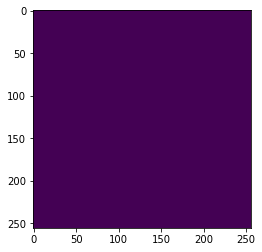

(Pdb) q


BdbQuit: 

In [21]:
past_seconds = 2
future_seconds = 4

for j in range(len(nusc.scene)//10):
    print(j)
    my_scene_token = nusc.scene[j]['token']
    scene_rec = nusc.get('scene', my_scene_token)
    #print(len(scene_rec))

    current_token = scene_rec['first_sample_token']
    current_seq = []
    
    for i in range(scene_rec['nbr_samples']): 
        #get current sample data
        sample_rec = nusc.get('sample', current_token)

        #get camera tokens
        camera_token = sample_rec['data']['CAM_FRONT']
        camera_token_FRONT_LEFT = sample_rec['data']['CAM_FRONT_LEFT']
        camera_token_FRONT_RIGHT = sample_rec['data']['CAM_FRONT_RIGHT']
        camera_token_BACK = sample_rec['data']['CAM_BACK']

        pointsensor_token = sample_rec['data']['LIDAR_TOP']
        pointsensor = nusc.get('sample_data', pointsensor_token)

        #get camera info
        cam = nusc.get('sample_data', camera_token)
        cam_front_left = nusc.get('sample_data', camera_token_FRONT_LEFT)
        cam_front_right = nusc.get('sample_data', camera_token_FRONT_RIGHT)
        cam_back = nusc.get('sample_data', camera_token_BACK)

        orig_pc, times = LidarPointCloud.from_file_multisweep(nusc, sample_rec, 'LIDAR_TOP', 'LIDAR_TOP', nsweeps=10)

        #get ego vehicle pose
        pose_record = nusc.get('ego_pose', pointsensor['ego_pose_token'])

        #get point cloud in camera frame prior to putting inside image plane
        pc, global_frame_pc = project_points_to_image(orig_pc, pointsensor, cam) 
        pc_front_left, _ = project_points_to_image(orig_pc, pointsensor, cam_front_left)
        pc_front_right, _ = project_points_to_image(orig_pc, pointsensor, cam_front_right)
        pc_back, _ = project_points_to_image(orig_pc, pointsensor, cam_back)
        
#         if 'sweeps' in cam['filename'] or 'sweeps' in cam_front_left['filename'] or 'sweeps' in cam_front_right['filename'] or 'sweeps' in cam_back['filename']:
#             print("found in sweeps")

        #get image representation of camera data
        im = PIL.Image.open(osp.join(nusc.dataroot, cam['filename']))
        im_fl = PIL.Image.open(osp.join(nusc.dataroot, cam_front_left['filename']))
        im_fr = PIL.Image.open(osp.join(nusc.dataroot, cam_front_right['filename']))
        im_b = PIL.Image.open(osp.join(nusc.dataroot, cam_back['filename']))
        
         # Grab the depths (camera frame z axis points away from the camera).
        depths = pc.points[2, :]
        depths_front_left = pc_front_left.points[2,:]
        depths_front_right = pc_front_right.points[2,:]
        depths_back = pc_back.points[2,:]

        # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
        cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
        cs_record_front_left = nusc.get('calibrated_sensor', cam_front_left['calibrated_sensor_token'])
        cs_record_front_right = nusc.get('calibrated_sensor', cam_front_right['calibrated_sensor_token'])
        cs_record_back = nusc.get('calibrated_sensor', cam_back['calibrated_sensor_token'])

        #get matrix representation of camera image
        cam_data_arr_front = plt.imread(osp.join(nusc.dataroot, cam['filename']))
        cam_data_arr_front_left = plt.imread(osp.join(nusc.dataroot, cam_front_left['filename']))
        cam_data_arr_front_right = plt.imread(osp.join(nusc.dataroot, cam_front_right['filename']))
        cam_data_arr_back = plt.imread(osp.join(nusc.dataroot, cam_back['filename']))

        #get point cloud data in the image plane across all cameras
        points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)
        points_front_left = view_points(pc_front_left.points[:3, :], np.array(cs_record_front_left['camera_intrinsic']), normalize=True)
        points_front_right = view_points(pc_front_right.points[:3, :], np.array(cs_record_front_right['camera_intrinsic']), normalize=True)
        points_back = view_points(pc_back.points[:3, :], np.array(cs_record_back['camera_intrinsic']), normalize=True)

        #get points that are actually inside the image plane
        mask_front = mask_img_points(points, depths, im)
        mask_front_left = mask_img_points(points_front_left, depths_front_left, im_fl)
        mask_front_right = mask_img_points(points_front_right, depths_front_right, im_fr)
        mask_back = mask_img_points(points_back, depths_back, im_b)

        # get points inside the image
        valid_img_points_front = points[:, mask_front]
        valid_img_points_front_left = points_front_left[:, mask_front_left]
        valid_img_points_front_right = points_front_right[:, mask_front_right]
        valid_img_points_back = points_back[:, mask_back]

#         import pdb; pdb.set_trace()
        
        #perform point painting and get class per associated valid lidar point
        semantic_class_points_front = get_semantic_class(valid_img_points_front, cam_data_arr_front)   

        semantic_class_points_front_left = get_semantic_class(valid_img_points_front_left, cam_data_arr_front_left)   

        semantic_class_points_front_right = get_semantic_class(valid_img_points_front_right, cam_data_arr_front_right)   
        semantic_class_points_back = get_semantic_class(valid_img_points_back, cam_data_arr_back)   

        masks = [mask_front, mask_front_left, mask_front_right, mask_back]
        semantic_class_points = [semantic_class_points_front,\
                                 semantic_class_points_front_left,\
                                 semantic_class_points_front_right,\
                                 semantic_class_points_back]
        images = [im, im_fl, im_fr, im_b]

        current_seq.append((pc, global_frame_pc, pointsensor, pose_record, masks, semantic_class_points, images))
        
        #create sequences

        
        if len(current_seq) >= 12:
            intermediate_reps = []
            
            current_frame = i - 2*future_seconds + 1
            
            time_frame = current_seq[current_frame-2*past_seconds:-1]
            needed_ego_pose = current_seq[current_frame][3]

            res = 0.5
            offset = 64
            if len(current_seq) >= 13:
                import pdb; pdb.set_trace()

            yaw = Quaternion(needed_ego_pose['rotation']).yaw_pitch_roll[0]
            rotation_matrix = np.array([[np.cos(yaw), -np.sin(yaw)],[np.sin(yaw), np.cos(yaw)]]).T
#             import pdb; pdb.set_trace()
            #with ego pose, transform the corresponding point clouds in history to bev 
            count = 0
            for pc_h, gpc_orig, ps_h, ep_h, m, s_c_p, ims in time_frame:
            
                gpc_h = copy.deepcopy(gpc_orig)
                #generate target rep
                shifted_ep_h = np.expand_dims(np.array(ep_h['translation']),1) - np.expand_dims(needed_ego_pose['translation'], 1)
                transformed_ep_h = np.dot(rotation_matrix, shifted_ep_h[:2,:])
                x = math.floor((int(transformed_ep_h[0]) + offset)/res)
                y = math.floor((int(transformed_ep_h[1]) + offset)/res)
                target_rep = np.zeros((256,256))
                target_rep[y][x] += 1
                
                print(y,x)
                
#                 import pdb; pdb.set_trace()

                #generate all reps except target

                gpc_h.points[:3,:] -= np.expand_dims(needed_ego_pose['translation'], 1)
                gpc_h.points[:2,:] = np.dot(rotation_matrix, gpc_h.points[:2,:])
                
#                 import pdb; pdb.set_trace()
                
                min_coor_x = max(-offset + 1, np.min(gpc_h.points[0,:]))
                min_coor_y = max(-offset + 1, np.min(gpc_h.points[1,:]))
                
                max_coor_x = min(offset - 1, np.max(gpc_h.points[0,:]))
                max_coor_y = min(offset - 1, np.max(gpc_h.points[1,:]))
                
                print(min_coor_x, min_coor_y, max_coor_x, max_coor_y)
#                 import pdb; pdb.set_trace()
                #ensures we don't get lidar points that are too far away
                point_filter_1_x = gpc_h.points[0,:] > min_coor_x
                point_filter_1_y = gpc_h.points[1,:] > min_coor_y
                point_filter_1 = np.logical_and(point_filter_1_x, point_filter_1_y)

                point_filter_2_x = gpc_h.points[0,:] < max_coor_x
                point_filter_2_y = gpc_h.points[1,:] < max_coor_y
                point_filter_2 = np.logical_and(point_filter_2_x, point_filter_2_y)

                point_filter = np.logical_and(point_filter_1, point_filter_2)
                
#                 import pdb; pdb.set_trace()
                m_f, m_f_l, m_f_r, m_b = m[0], m[1], m[2], m[3]
                s_c_p_f, s_c_p_f_l, s_c_p_f_r, s_c_p_b = s_c_p[0], s_c_p[1], s_c_p[2], s_c_p[3]
#                 overall_mask  = np.logical_or(m_f, m_f_l)
#                 overall_mask  = np.logical_or(overall_mask, m_f_r)            
#                 overall_mask  = np.logical_or(overall_mask, m_b)


                all_colored = np.array([-1] * gpc_h.points.shape[1])
                all_colored[m_f] = s_c_p[0]
                all_colored[m_f_l] =  s_c_p[1]
                all_colored[m_f_r] = s_c_p[2]
                all_colored[m_b] = s_c_p[3]

                m_f_l, m_f_r = np.logical_and(point_filter, m_f_l),np.logical_and(point_filter, m_f_r)
                m_f, m_b = np.logical_and(point_filter, m_f),np.logical_and(point_filter, m_b)

                s_c_p_f = all_colored[m_f]
                s_c_p_f_l = all_colored[m_f_l]
                s_c_p_f_r = all_colored[m_f_r]
                s_c_p_b = all_colored[m_b]
                
#                 print_stats(s_c_p)
                
                
                
#                 import pdb; pdb.set_trace()
                road_rep_fl, lane_rep_fl, obstacle_rep_fl, vehicle_rep_fl = get_intermediate_rep(gpc_h.points, m_f_l, s_c_p_f_l)
                road_rep_fr, lane_rep_fr, obstacle_rep_fr, vehicle_rep_fr = get_intermediate_rep(gpc_h.points, m_f_r, s_c_p_f_r)

                road_rep_f, lane_rep_f, obstacle_rep_f, vehicle_rep_f = get_intermediate_rep(gpc_h.points, m_f, s_c_p_f)
                road_rep_b, lane_rep_b, obstacle_rep_b, vehicle_rep_b = get_intermediate_rep(gpc_h.points, m_b, s_c_p_b)

                road_rep = road_rep_fl + road_rep_fr + road_rep_f + road_rep_b
                lane_rep = lane_rep_fl + lane_rep_fr + lane_rep_f + lane_rep_b

                obstacle_rep = obstacle_rep_fl + obstacle_rep_fr + obstacle_rep_f + obstacle_rep_b
                vehicle_rep = vehicle_rep_fl + vehicle_rep_fr + vehicle_rep_f + vehicle_rep_b
                print(np.count_nonzero(road_rep), np.count_nonzero(lane_rep),  np.count_nonzero(obstacle_rep), np.count_nonzero(vehicle_rep), np.count_nonzero(target_rep))
                
                if count == 3: 
                    import pdb; pdb.set_trace()
                base_file_path = "./representations"
                #plot the dilated versions of the intermediate reps 
                
                kernel = np.ones((5,5), np.uint8)
                dilation = cv2.dilate(road_rep,kernel,iterations = 1)
                plt.imshow(dilation)
                plt.savefig(base_file_path + "/dilated_reps/road/road_{}.png".format(count))
                plt.clf()
                
                kernel = np.ones((2,2), np.uint8)
                dilation = cv2.dilate(lane_rep,kernel,iterations = 1)
                plt.imshow(dilation)
                plt.savefig(base_file_path + "/dilated_reps/lane/lane_{}.png".format(count))
                plt.clf()
                
                kernel = np.ones((5,5), np.uint8)
                dilation = cv2.dilate(obstacle_rep,kernel,iterations = 1)
                plt.imshow(dilation)
                plt.savefig(base_file_path + "/dilated_reps/obstacle/obstacle_{}.png".format(count))
                plt.clf()
                
                kernel = np.ones((2,2), np.uint8)
                dilation = cv2.dilate(vehicle_rep,kernel,iterations = 1)
                plt.imshow(dilation)
                plt.savefig(base_file_path + "/dilated_reps/vehicles/vehicle_{}.png".format(count))
                plt.clf()
                
                blur = cv2.GaussianBlur(copy.deepcopy(target_rep),(5,5),0)
                
                plt.imshow(blur)
                plt.savefig(base_file_path + "/dilated_reps/target/target_{}.png".format(count))
                plt.clf()
                                
                #plot current versions of the intermediate reps 
                plt.imshow(road_rep)
                plt.savefig(base_file_path + "/non_dilated_reps/road/road_{}.png".format(count))
                plt.clf()
                
                plt.imshow(lane_rep)
                plt.savefig(base_file_path + "/non_dilated_reps/lane/lane_{}.png".format(count))
                plt.clf()
                
                plt.imshow(obstacle_rep)
                plt.savefig(base_file_path +"/non_dilated_reps/obstacle/obstacle_{}.png".format(count))
                plt.clf()
                assert(np.sum(target_rep) == 1)
                      
                plt.imshow(target_rep)
                plt.savefig(base_file_path + "/non_dilated_reps/target/target_{}.png".format(count))
                plt.clf()                
                
                            
                plt.imshow(vehicle_rep)
                plt.savefig(base_file_path + "/non_dilated_reps/vehicles/vehicle_{}.png".format(count))
                plt.clf()                
                
                intermediate_reps.append([road_rep, lane_rep, obstacle_rep, vehicle_rep, target_rep])
                count+=1 
            
            for k,data in enumerate(intermediate_reps):
                if k < len(intermediate_reps) - 1:
                    data.append(intermediate_reps[k+1][4])
#             import pdb; pdb.set_trace()
        
        if not sample_rec['next'] == "":
            current_token = sample_rec['next']
        else:
            has_more = False
            
        if len(current_seq) >= 12:
            import pdb; pdb.set_trace()
            

In [18]:
def get_intermediate_rep(BEV_points, mask, semantic_class_points):
    corresponding_BEV_points= BEV_points[:,mask] 
    
    num_points = corresponding_BEV_points.shape[1]
    lane_rep =  np.zeros((256,256))
    road_rep = np.zeros((256,256))
    obstacle_rep = np.zeros((256,256))
    vehicle_rep = np.zeros((256,256))
    res = 0.5
    #defining 128x128 region surrounding origin 
    offset = 64
    for i in range(num_points):
        current_point = np.round(corresponding_BEV_points[:,i][:2])
        x = math.floor((int(current_point[0]) + offset)/res)
        y = math.floor((int(current_point[1]) + offset)/res)
        if x < 0 or y < 0 or x >= 256 or y >= 256: 
            import pdb; pdb.set_trace()
        semantic_class = semantic_class_points[i]
        if semantic_class == class_to_idx['Road']:
            road_rep[y][x] += 1
            
        if semantic_class == class_to_idx['Lane Marking - General'] or semantic_class == class_to_idx['Lane Marking - Crosswalk']:
            lane_rep[y][x] += 1
            
        if semantic_class == class_to_idx['Building'] or semantic_class == class_to_idx['Curb'] or semantic_class == class_to_idx['Vegetation']:
            obstacle_rep[y][x] += 1
        
        if semantic_class == class_to_idx['Car'] or semantic_class == class_to_idx['Truck']:
            vehicle_rep[y][x] += 1
    
    return road_rep, lane_rep, obstacle_rep, vehicle_rep
    

In [ ]:

            
### NEW STRUCTURE
#for every scene (85)
    #for every sequence (start of history to end of future ground truth) around 28 or 29
        #store intermediate reps with ground truths

In [ ]:
#talk to Nachiket about ground truths
#create data directory above
#work on training script 
#work on validation script - mimic what authors did